In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from timeit import default_timer as timer

/home/iesus/Documents/mastering_pytorch/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calcular la func de pérdida y precisión por época e imprimir lo que está sucediendo
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() 
    
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Ajustar la pérdida y la precisión por época e imprimir lo que está sucediendo
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    
    return test_loss, test_acc

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def print_train_time(start, end, device=None):
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):
    loss, acc = 0, 0
    model.eval()
    device = next(model.parameters()).device  # Detecta el device del modelo
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)  # Mueve datos al mismo device que el modelo
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) 

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

def plot_loss_curve(train_losses, test_losses):
    train_losses = [float(l) for l in train_losses]
    test_losses = [float(l) for l in test_losses]
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy_curve(train_accuracies, test_accuracies):
    train_accuracies = [float(a) for a in train_accuracies]
    test_accuracies = [float(a) for a in test_accuracies]
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label="Train accuracy")
    plt.plot(test_accuracies, label="Test accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [4]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, 
                                   transform=ToTensor(), target_transform=None)

test_data = datasets.FashionMNIST(root="data", train=False, download=True, 
                                  transform=ToTensor())

class_names = train_data.classes

print(f"Nombre de las clases: {class_names}")
print(f"Cantidad de clases: {len(class_names)}")
print(f"Cantidad de imágenes de entrenamiento: {len(train_data)}")
print(f"Cantidad de imágenes de prueba: {len(test_data)}")

Nombre de las clases: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Cantidad de clases: 10
Cantidad de imágenes de entrenamiento: 60000
Cantidad de imágenes de prueba: 10000


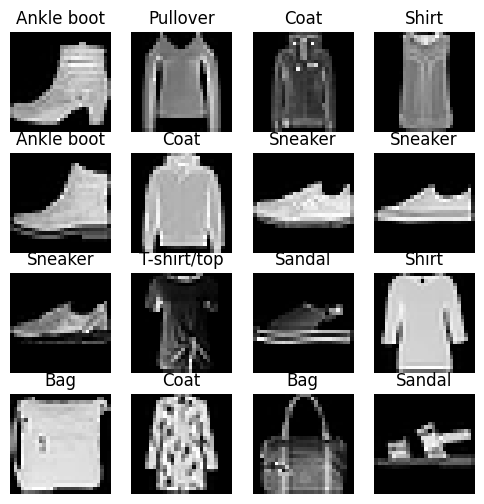

In [5]:
fig = plt.figure(figsize=(6, 6))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Cantidad de batches de entrenamiento: {len(train_dataloader)}")
print(f"Cantidad de batches de prueba: {len(test_dataloader)}")
print(f"Un batch de entrenamiento tiene la siguiente forma: {next(iter(train_dataloader))[0].shape}")

Cantidad de batches de entrenamiento: 1875
Cantidad de batches de prueba: 313
Un batch de entrenamiento tiene la siguiente forma: torch.Size([32, 1, 28, 28])


In [7]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=16, 
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, 
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*7*7, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))
model_2.to(device)
model_2


FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=10, bias=True)
  )
)

In [8]:
images = torch.randn(size=(32, 1, 28, 28)) 
test_image = images[0] 
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 

Image batch shape: torch.Size([32, 1, 28, 28]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.001)

In [10]:
torch.manual_seed(42)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Measure time
train_time_start_model_2 = timer()

# Train and test model 
epochs = 25
for epoch in tqdm(range(epochs)):
    print("*"*25)
    print(f"Epoch: {epoch+1}")
    train_loss, train_acc = train_step(data_loader=train_dataloader, model=model_2, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc = test_step(data_loader=test_dataloader, model=model_2, loss_fn=loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end=train_time_end_model_2, device=device)

  0%|          | 0/25 [00:00<?, ?it/s]

*************************
Epoch: 1
Train loss: 2.16477 | Train accuracy: 21.80%


  4%|▍         | 1/25 [00:08<03:18,  8.26s/it]

Test loss: 1.19090 | Test accuracy: 62.35%

*************************
Epoch: 2
Train loss: 0.82867 | Train accuracy: 69.68%


  8%|▊         | 2/25 [00:16<03:03,  7.98s/it]

Test loss: 0.76074 | Test accuracy: 70.88%

*************************
Epoch: 3
Train loss: 0.69275 | Train accuracy: 75.15%


 12%|█▏        | 3/25 [00:23<02:52,  7.85s/it]

Test loss: 0.67681 | Test accuracy: 76.19%

*************************
Epoch: 4
Train loss: 0.63981 | Train accuracy: 77.04%


 16%|█▌        | 4/25 [00:31<02:43,  7.79s/it]

Test loss: 0.62995 | Test accuracy: 77.38%

*************************
Epoch: 5
Train loss: 0.60382 | Train accuracy: 78.18%


 20%|██        | 5/25 [00:39<02:35,  7.77s/it]

Test loss: 0.60149 | Test accuracy: 78.13%

*************************
Epoch: 6
Train loss: 0.57222 | Train accuracy: 79.48%


 24%|██▍       | 6/25 [00:46<02:27,  7.75s/it]

Test loss: 0.58236 | Test accuracy: 78.77%

*************************
Epoch: 7
Train loss: 0.54347 | Train accuracy: 80.51%


 28%|██▊       | 7/25 [00:54<02:19,  7.75s/it]

Test loss: 0.55534 | Test accuracy: 79.88%

*************************
Epoch: 8
Train loss: 0.51850 | Train accuracy: 81.37%


 32%|███▏      | 8/25 [01:02<02:11,  7.73s/it]

Test loss: 0.52385 | Test accuracy: 81.26%

*************************
Epoch: 9
Train loss: 0.49542 | Train accuracy: 82.50%


 36%|███▌      | 9/25 [01:10<02:04,  7.75s/it]

Test loss: 0.49790 | Test accuracy: 82.39%

*************************
Epoch: 10
Train loss: 0.47689 | Train accuracy: 83.13%


 40%|████      | 10/25 [01:18<01:57,  7.85s/it]

Test loss: 0.48740 | Test accuracy: 83.07%

*************************
Epoch: 11
Train loss: 0.45969 | Train accuracy: 83.82%


 44%|████▍     | 11/25 [01:26<01:51,  7.98s/it]

Test loss: 0.47945 | Test accuracy: 82.56%

*************************
Epoch: 12
Train loss: 0.44630 | Train accuracy: 84.26%


 48%|████▊     | 12/25 [01:34<01:45,  8.09s/it]

Test loss: 0.45500 | Test accuracy: 84.11%

*************************
Epoch: 13
Train loss: 0.43300 | Train accuracy: 84.87%


 52%|█████▏    | 13/25 [01:42<01:36,  8.02s/it]

Test loss: 0.44454 | Test accuracy: 84.37%

*************************
Epoch: 14
Train loss: 0.42372 | Train accuracy: 85.10%


 56%|█████▌    | 14/25 [01:50<01:27,  7.95s/it]

Test loss: 0.43520 | Test accuracy: 85.01%

*************************
Epoch: 15
Train loss: 0.41492 | Train accuracy: 85.40%


 60%|██████    | 15/25 [01:58<01:18,  7.89s/it]

Test loss: 0.44144 | Test accuracy: 84.00%

*************************
Epoch: 16
Train loss: 0.40709 | Train accuracy: 85.80%


 64%|██████▍   | 16/25 [02:05<01:10,  7.84s/it]

Test loss: 0.43940 | Test accuracy: 84.29%

*************************
Epoch: 17
Train loss: 0.39890 | Train accuracy: 85.91%


 68%|██████▊   | 17/25 [02:13<01:02,  7.80s/it]

Test loss: 0.43665 | Test accuracy: 84.15%

*************************
Epoch: 18
Train loss: 0.39214 | Train accuracy: 86.26%


 72%|███████▏  | 18/25 [02:21<00:54,  7.78s/it]

Test loss: 0.43117 | Test accuracy: 84.88%

*************************
Epoch: 19
Train loss: 0.38590 | Train accuracy: 86.45%


 76%|███████▌  | 19/25 [02:29<00:47,  7.84s/it]

Test loss: 0.41235 | Test accuracy: 85.37%

*************************
Epoch: 20
Train loss: 0.37999 | Train accuracy: 86.59%


 80%|████████  | 20/25 [02:37<00:39,  7.96s/it]

Test loss: 0.40922 | Test accuracy: 85.33%

*************************
Epoch: 21
Train loss: 0.37302 | Train accuracy: 86.80%


 84%|████████▍ | 21/25 [02:45<00:31,  7.88s/it]

Test loss: 0.39944 | Test accuracy: 86.00%

*************************
Epoch: 22
Train loss: 0.36818 | Train accuracy: 87.04%


 88%|████████▊ | 22/25 [02:53<00:23,  7.84s/it]

Test loss: 0.38743 | Test accuracy: 86.78%

*************************
Epoch: 23
Train loss: 0.36432 | Train accuracy: 87.20%


 92%|█████████▏| 23/25 [03:00<00:15,  7.83s/it]

Test loss: 0.37741 | Test accuracy: 87.06%

*************************
Epoch: 24
Train loss: 0.35834 | Train accuracy: 87.30%


 96%|█████████▌| 24/25 [03:08<00:07,  7.82s/it]

Test loss: 0.37886 | Test accuracy: 86.60%

*************************
Epoch: 25
Train loss: 0.35396 | Train accuracy: 87.46%


100%|██████████| 25/25 [03:16<00:00,  7.86s/it]

Test loss: 0.37212 | Test accuracy: 87.16%


Train time on cuda: 196.401 seconds


/tmp/ipykernel_4949/2520961332.py:104: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  train_losses = [float(l) for l in train_losses]


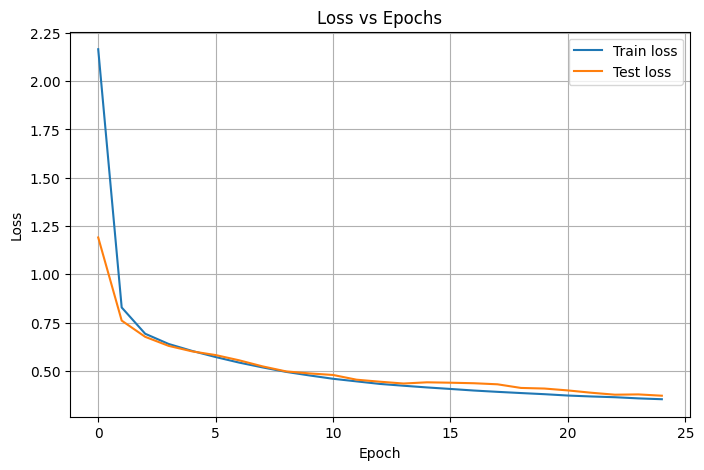

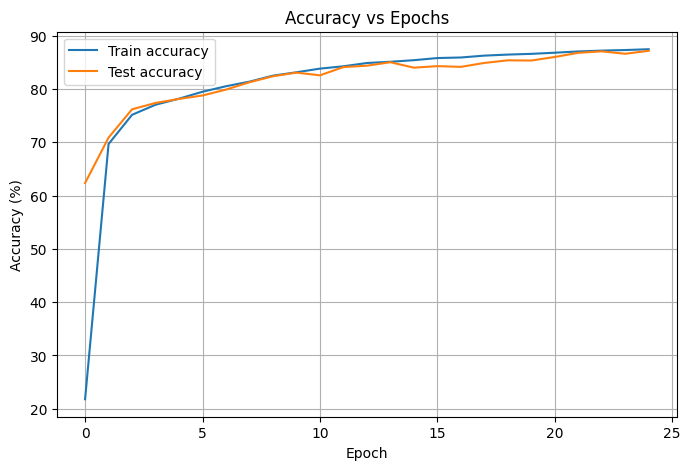

In [11]:
plot_loss_curve(train_losses, test_losses)
plot_accuracy_curve(train_accuracies, test_accuracies)

In [12]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3721240162849426,
 'model_acc': 87.16054313099042}

Test class labels: [2, 6, 8, 5, 2, 0, 1, 1, 5]
Predicted class labels: tensor([6, 3, 8, 5, 6, 2, 1, 1, 5])


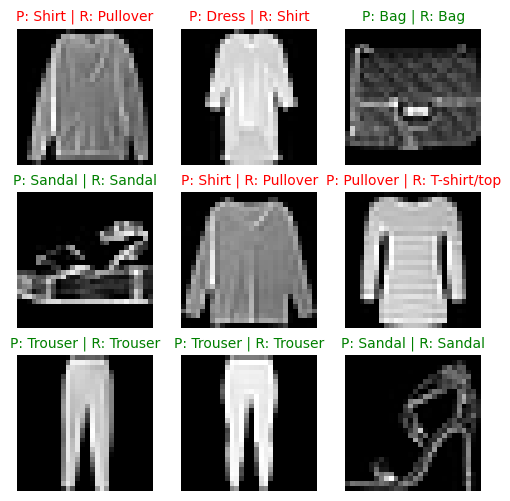

In [13]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=model_2, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

print(f"Test class labels: {test_labels}")
print(f"Predicted class labels: {pred_classes}")

plt.figure(figsize=(6, 6))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 

  title_text = f"P: {pred_label} | R: {truth_label}"
  
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)

In [14]:
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)

    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:00<00:00, 358.80it/s]


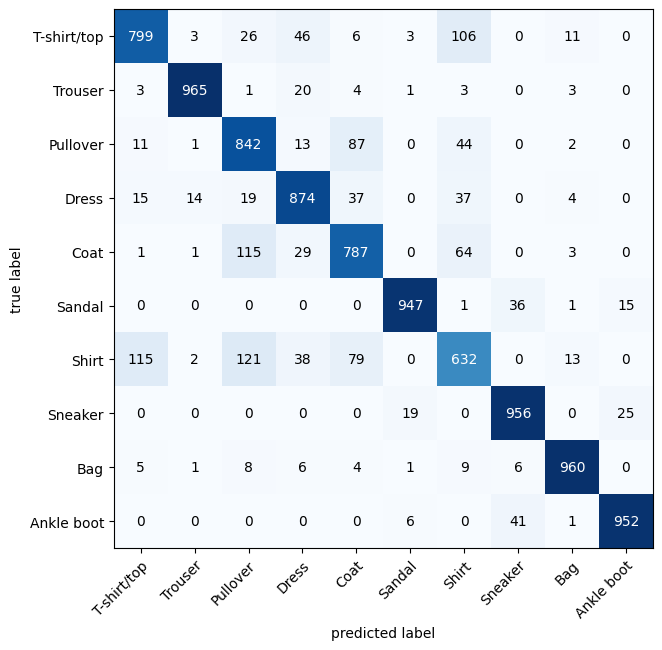

In [15]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(7, 7)
)